In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from collections import deque
from tqdm import tqdm

In [2]:
try:
  df = pd.read_csv("/content/Walmart Actual DataSet.csv")
  print("File loaded successfully")
except FileNotFoundError:
  print("File not found. Please check the file path.")

File loaded successfully


In [3]:
df

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667


In [ ]:
df.info()

In [ ]:
df.isnull().sum()

In [ ]:
df.dupilcated().sum()

In [4]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df = df.sort_values(by=['Store', 'Date']).reset_index(drop=True)

In [5]:
def create_features(df):
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.isocalendar().week.astype(int)
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Quarter'] = df['Date'].dt.quarter
    df['DayOfYear'] = df['Date'].dt.dayofyear
    df['Store'] = df['Store'].astype(int)

    # Average sales per store
    df['Store_Avg_Sales'] = df.groupby('Store')['Weekly_Sales'].transform('mean')

    # Lagged features
    for col in ['Temperature','Fuel_Price','CPI','Unemployment']:
        df[f'{col}_Lag_1'] = df.groupby('Store')[col].shift(1)

    # Holiday flags
    df['Is_SuperBowl_Week'] = ((df['Date'].dt.month==2) & df['Date'].dt.day.between(5,15)).astype(int)
    df['Is_LaborDay_Week'] = ((df['Date'].dt.month==9) & df['Date'].dt.day.between(5,15)).astype(int)
    df['Is_Thanksgiving_Week'] = ((df['Date'].dt.month==11) & df['Date'].dt.day.between(20,30)).astype(int)
    df['Is_Christmas_Period'] = ((df['Date'].dt.month==12) & df['Date'].dt.day.between(20,31)).astype(int)

    # Weekly sales lags
    lags = [1,2,4,8,12,52]
    for lag in lags:
        df[f'Weekly_Sales_Lag_{lag}'] = df.groupby('Store')['Weekly_Sales'].shift(lag)

    # Rolling features
    df['Rolling_Mean_4'] = df.groupby('Store')['Weekly_Sales'].transform(lambda x: x.shift(1).rolling(4).mean())
    df['Rolling_Std_4'] = df.groupby('Store')['Weekly_Sales'].transform(lambda x: x.shift(1).rolling(4).std())

    # Weight for holidays
    df['Weight'] = np.where(df['Holiday_Flag']==1, 5, 1)

    # Drop rows with critical missing features
    df = df.dropna(subset=['Weekly_Sales_Lag_1','Rolling_Mean_4']).reset_index(drop=True)

    return df

# Create features
df_model = create_features(df.copy())

In [6]:
# Encode categorical columns
cat_cols = ['Month','DayOfWeek','Quarter']
df_model_enc = pd.get_dummies(df_model, columns=cat_cols, drop_first=False)

# Define features from the encoded dataframe
features = [col for col in df_model_enc.columns if col not in ['Date','Weekly_Sales','Weight']]



In [7]:

# Example train-test split
max_date = df_model_enc['Date'].max()
test_split_date = max_date - pd.Timedelta(weeks=30)
train_df = df_model_enc[df_model_enc['Date'] <= test_split_date]
test_df = df_model_enc[df_model_enc['Date'] > test_split_date]

X_train, y_train = train_df[features], train_df['Weekly_Sales']
X_test, y_test = test_df[features], test_df['Weekly_Sales']
w_train, w_test = train_df['Weight'].values, test_df['Weight'].values


print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

Training samples: 4905, Test samples: 1350


In [8]:
# Train XGBoost model with DMatrix

dtrain = xgb.DMatrix(X_train, label=y_train, weight=w_train)
dtest = xgb.DMatrix(X_test, label=y_test, weight=w_test)

params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

evals = [(dtrain, 'train'), (dtest, 'eval')]

xgb_model_booster = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=50
)

[0]	train-rmse:561850.44314	eval-rmse:513784.57244
[50]	train-rmse:77963.05870	eval-rmse:80238.34247
[100]	train-rmse:46268.56072	eval-rmse:66482.51298
[150]	train-rmse:37504.32294	eval-rmse:64836.21106
[200]	train-rmse:31807.90653	eval-rmse:64486.62162
[250]	train-rmse:28019.52330	eval-rmse:64357.76281
[264]	train-rmse:27106.73980	eval-rmse:64289.53978


In [9]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    seed=42)

In [10]:
# Fit without early stopping first
xgb_model.fit(X_train, y_train, sample_weight=w_train, verbose=True)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [11]:
y_pred = xgb_model.predict(X_test)

In [13]:
test_df['Predictions'] = y_pred

/tmp/ipython-input-3176129324.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Predictions'] = y_pred


In [12]:
# Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
wmae = np.sum(w_test * np.abs(y_test - y_pred)) / np.sum(w_test)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}, WMAE: {wmae:.2f}")


MAE: 42975.19, RMSE: 67009.91, R2: 0.9845, WMAE: 43061.68


In [14]:
def recursive_forecast(store_df, model, features, horizon = 30):
    store_df = store_df.sort_values('Date').reset_index(drop=True)

    # Ensure all features exist
    for feat in features:
        if feat not in store_df.columns:
            store_df[feat] = 0

    lag_cols = [f'Weekly_Sales_Lag_{lag}' for lag in [1, 2, 4, 8, 12, 52]]
    lag_dict = {col: deque(store_df[col].tail(int(col.split('_')[-1])),
                           maxlen=int(col.split('_')[-1])) for col in lag_cols}

    last_row = store_df.iloc[-1].copy()
    predictions = []

    for _ in range(horizon):
        # Update lag features
        for col in lag_cols:
            last_row[col] = lag_dict[col][-1] if len(lag_dict[col]) > 0 else 0

        # Rolling mean
        last_row['Rolling_Mean_4'] = (
            np.mean(list(lag_dict['Weekly_Sales_Lag_4']))
            if len(lag_dict['Weekly_Sales_Lag_4']) > 0 else 0
        )
        # Prepare input for model
        X_input = pd.DataFrame([last_row[features].fillna(0).values], columns=features)

        # Predict
        y_pred = model.predict(xgb.DMatrix(X_input))[0]
        predictions.append(y_pred)

        # Update lag dict
        for col in lag_cols:
            lag_dict[col].append(y_pred)

        # Advance date
        last_row['Date'] += pd.Timedelta(weeks=1)
        last_row['Week'] = (last_row['Week'] + 1) % 52
        if last_row['Week'] == 0:
            last_row['Year'] += 1

    forecast_dates = pd.date_range(store_df['Date'].iloc[-1] + pd.Timedelta(weeks=1),
                                   periods=horizon, freq='W')

    return pd.DataFrame({
        'store_id': store_df['Store'].iloc[-1],
        'Date': forecast_dates,
        'Weekly_Sales': predictions
    })


In [15]:
forecast_list = []

print("\n-30week forecasts for all stores...\n")
for store_id in tqdm(df_model_enc['Store'].unique(), desc="Forecasting Stores"):
    store_df = df_model_enc[df_model_enc['Store'] == store_id]
    fc_df = recursive_forecast(store_df, xgb_model_booster, features, horizon=30)
    forecast_list.append(fc_df)

forecast_all = pd.concat(forecast_list, ignore_index=True)
forecast_all['Data_Type'] = 'Forecast'


-30week forecasts for all stores...



Forecasting Stores: 100%|██████████| 45/45 [00:22<00:00,  2.02it/s]


In [16]:
actuals_df = df_model_enc[['Store', 'Date', 'Weekly_Sales']].copy()
actuals_df.rename(columns={'Store': 'store_id'}, inplace=True)
actuals_df['Data_Type'] = 'Actual'


In [17]:
# Combine both
powerbi_df = pd.concat([actuals_df, forecast_all], ignore_index=True)
powerbi_df = powerbi_df.sort_values(['store_id', 'Date']).reset_index(drop=True)


In [18]:
export_path = "Walmart_Sales_Forecast_AllStores.csv"
powerbi_df.to_csv(export_path, index=False)

Testing for Forecasting

In [19]:
print(f"\nPower BI dataset created successfully!")
print(f"File saved at: {export_path}")
print(f"Total rows: {len(powerbi_df):,}")
print(f"Unique stores: {powerbi_df['store_id'].nunique()}")
print("\nSample preview:")
print(powerbi_df.head(10))


Power BI dataset created successfully!
File saved at: Walmart_Sales_Forecast_AllStores.csv
Total rows: 7,605
Unique stores: 45

Sample preview:
   store_id       Date  Weekly_Sales Data_Type
0         1 2010-03-05    1554806.68    Actual
1         1 2010-03-12    1439541.59    Actual
2         1 2010-03-19    1472515.79    Actual
3         1 2010-03-26    1404429.92    Actual
4         1 2010-04-02    1594968.28    Actual
5         1 2010-04-09    1545418.53    Actual
6         1 2010-04-16    1466058.28    Actual
7         1 2010-04-23    1391256.12    Actual
8         1 2010-04-30    1425100.71    Actual
9         1 2010-05-07    1603955.12    Actual


In [20]:
print(f"\nPower BI dataset created successfully!")
print(f"File saved at: {export_path}")
print(f"Total rows: {len(powerbi_df):,}")
print(f"Unique stores: {powerbi_df['store_id'].nunique()}")
print("\nSample preview:")
print(powerbi_df.tail(30))


Power BI dataset created successfully!
File saved at: Walmart_Sales_Forecast_AllStores.csv
Total rows: 7,605
Unique stores: 45

Sample preview:
      store_id       Date  Weekly_Sales Data_Type
7575        45 2012-11-04   756941.5625  Forecast
7576        45 2012-11-11   766015.4375  Forecast
7577        45 2012-11-18   767788.1875  Forecast
7578        45 2012-11-25   761197.1875  Forecast
7579        45 2012-12-02   810712.5000  Forecast
7580        45 2012-12-09   819532.4375  Forecast
7581        45 2012-12-16   845286.4375  Forecast
7582        45 2012-12-23   871858.1250  Forecast
7583        45 2012-12-30   907563.6250  Forecast
7584        45 2013-01-06   867233.8125  Forecast
7585        45 2013-01-13   833317.3750  Forecast
7586        45 2013-01-20   775406.5000  Forecast
7587        45 2013-01-27   755402.1875  Forecast
7588        45 2013-02-03   732419.2500  Forecast
7589        45 2013-02-10   768947.1250  Forecast
7590        45 2013-02-17   784840.5625  Forecast
7591 

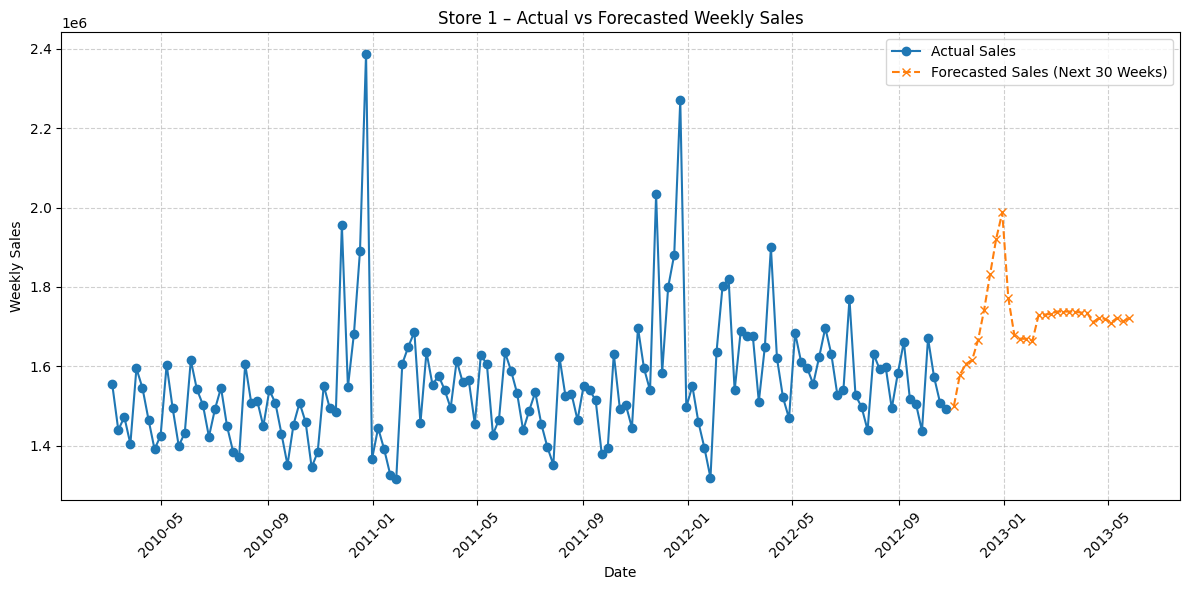

In [21]:
store_id = 1  # Example store
store_data = powerbi_df[powerbi_df['store_id'] == store_id]
actual_df = store_data[store_data['Data_Type'] == 'Actual']
forecast_df = store_data[store_data['Data_Type'] == 'Forecast']

plt.figure(figsize=(12, 6))
plt.plot(actual_df['Date'], actual_df['Weekly_Sales'], label='Actual Sales', marker='o')
plt.plot(forecast_df['Date'], forecast_df['Weekly_Sales'], label='Forecasted Sales (Next 30 Weeks)', marker='x', linestyle='--')
plt.title(f"Store {store_id} – Actual vs Forecasted Weekly Sales")
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

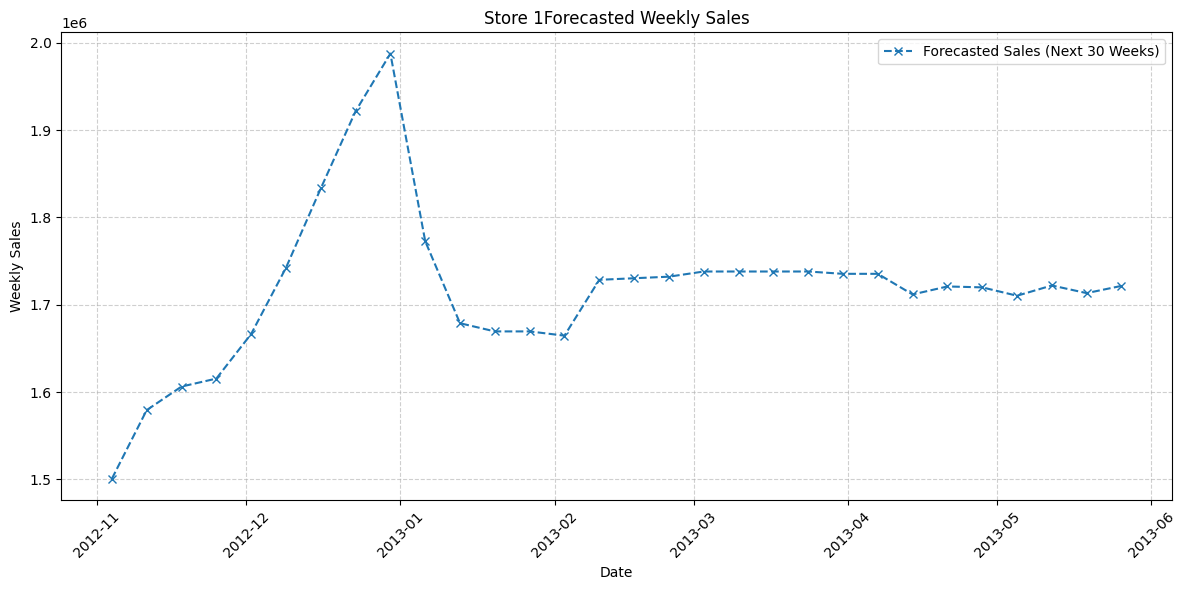

In [22]:
store_id = 1  # Example store
store_data = powerbi_df[powerbi_df['store_id'] == store_id]
forecast_df = store_data[store_data['Data_Type'] == 'Forecast']

plt.figure(figsize=(12, 6))
plt.plot(forecast_df['Date'], forecast_df['Weekly_Sales'], label='Forecasted Sales (Next 30 Weeks)', marker='x', linestyle='--')
plt.title(f"Store {store_id}Forecasted Weekly Sales")
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

1


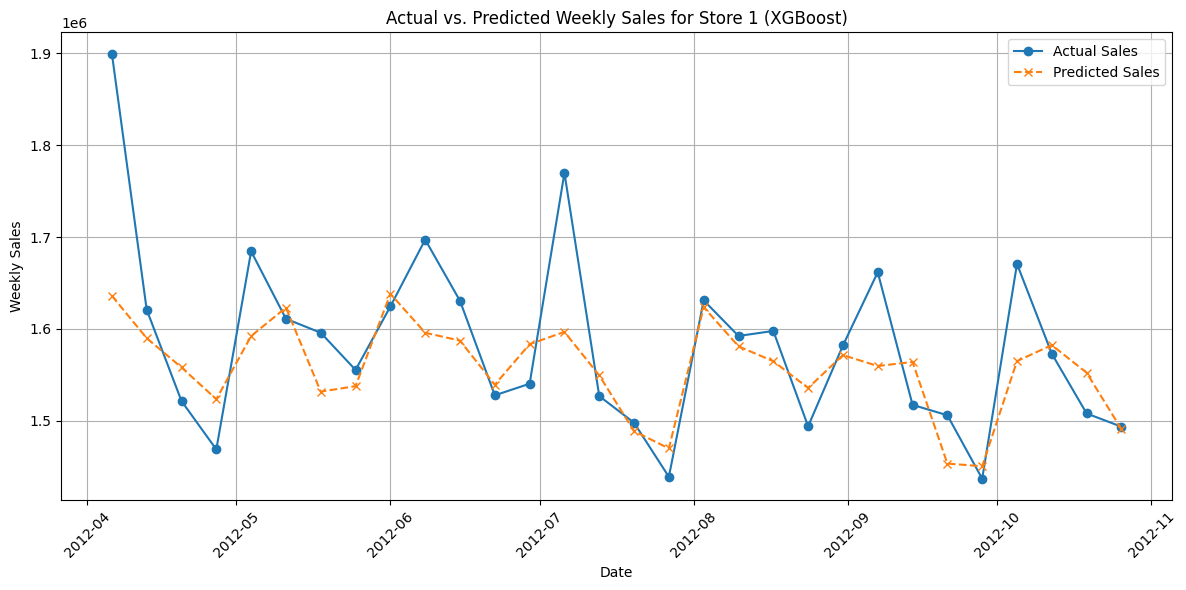

In [23]:
print(store_id)
store_id = 1
store_test_df = test_df[test_df['Store'] == store_id].sort_values('Date')

plt.figure(figsize=(12, 6))
plt.plot(store_test_df['Date'], store_test_df['Weekly_Sales'], label='Actual Sales', marker='o', linestyle='-')
plt.plot(store_test_df['Date'], store_test_df['Predictions'], label='Predicted Sales', marker='x', linestyle='--')
plt.title(f'Actual vs. Predicted Weekly Sales for Store {store_id} (XGBoost)')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [24]:
print(store_id)
store_id = 1
store_df = df_model_enc[df_model_enc['Store']==store_id]
forecast_30w = recursive_forecast(store_df, xgb_model_booster, features, horizon=30)

print(forecast_30w)

1
    store_id       Date  Weekly_Sales
0          1 2012-11-04   1500716.875
1          1 2012-11-11   1579306.500
2          1 2012-11-18   1606287.125
3          1 2012-11-25   1615404.500
4          1 2012-12-02   1666478.125
5          1 2012-12-09   1742282.750
6          1 2012-12-16   1833232.500
7          1 2012-12-23   1921654.875
8          1 2012-12-30   1987664.500
9          1 2013-01-06   1772803.125
10         1 2013-01-13   1678818.375
11         1 2013-01-20   1669452.750
12         1 2013-01-27   1669452.750
13         1 2013-02-03   1664593.375
14         1 2013-02-10   1728536.250
15         1 2013-02-17   1730356.375
16         1 2013-02-24   1732130.250
17         1 2013-03-03   1738065.375
18         1 2013-03-10   1738065.375
19         1 2013-03-17   1738065.375
20         1 2013-03-24   1738065.375
21         1 2013-03-31   1735409.500
22         1 2013-04-07   1735409.500
23         1 2013-04-14   1711784.500
24         1 2013-04-21   1720939.250
25        